# Introduction

The previous version of the algorithm did not have sufficiently tight bounds. Hopefully this version will improve on this. We explain the algorithm, then implement it, step by step in the notebook below.

1) Consider the GP prediction as the sum of exponentiated quadratics centred on all the training points.
2) Split the world into hypercubes.
3) Consider one dimension d.
4) Find how much each of the EQs changes over a given dimension (d) within each hypercube, effectively we just evaluate each EQ in the one dimension (d) at the start and end of the hypercube. We use these 'integrals' (of the derivative over d) as the peak values in the following mixture of Gaussians... we call this result $D^{all}$. Note that the locations can lie outside the hypercube, in the non-d dimensions.
5) Repeat the above but subtract the maximum of the EQ (e.g. if it has a peak that is inside the hypercube this will be different from the result in step 4) from its minimum. We again use these differences as peak values in the following... we call this $D^+$

6) We reintroduce the other dimensions of the hypercube. We can imagine the total change made to the predictions over the d-1 plane (of remaining dimensions) by moving a $d-1$ plane from one side of the hypercube to the other (along dimension d). This can be represented as a series of gaussians (EQs), each centred at one of the training points.

<pre>
d=2 example, n=3.        ------> sum of EQs   
                       |    .
                       |      .
      x                |       .  <-x
 ______________        |__   .
|              |  ,    |  .
|        o     | /|\   | .        <-o
|              |  |    |   .
|   x          |  |    |      .   <-x maximum within bounds of hypercube
|______________|  |z   |__   .
  ---------> d         |   .
                       |  .
                       | .

training points
x with weight = 1
o with weight = -1
</pre>

In the figure, imagine the distribution along the other axis (z) - it will be three EQs over one ($d-1$) dimensions. This sum will be the sum of three EQs (of d-1) dimensions centred at the locations of the training points (with the dth dimension removed).

7) We want to find the largest change possible in the prediction by moving along the d-axis, over the hypercube, both if we've stopped the integration somewhere within it, or if the integration was over the whole cube. Hence we needed the two results (from 4 and 5)...
8) We therefore will later be interested in the largest value in the $d-1$ space of this sum of gaussians. We will also be interested in the case in which the negative EQs are removed.

9) We next consider lists of hypercubes that one needs to pass through to get from the start to the end of dimension d. E.g. in this figure you need to pass through for example C, I, D and H. A full list of possible combinations will need to be made, e.g.:
<pre>
C I D H
C I D G
B D G
B D F
..etc

 ________________
|    |  |    |  |
| b  | d|    |H |
|   C|I | D  |_f|
|____|__|  e |G |
|   B c |    |__|
|_______|____|F |
|            |__|
xa   x  H    |E |
|____________|__|
0 1 2 3 4 5 6 7 8

Where A-I are the 9 hypercuboids, a-f are the peaks of the EQs.</pre>

10) For each list we need to consider all possible start and ends, for the first list the possible combinations are:
<pre>
C->C
C->I
C->D
C->H
I->I
I->D
..etc
</pre>
11) For each combination we then combine all the EQs from the hypercubes:
E.g. for the C->D list:

[$D^+$ EQs from <texttt>C</texttt>] + [$D^{all}$ EQs from <texttt>I</texttt>] + [$D^+$ EQs from <texttt>D</texttt>]


So the $D^+$ for hypercube C, would consist of:
- for a the difference between the minima and maxima of the value of a's EQ between 0 to 2.5 along a's other axes (i.e between the two bold xs)
- the same computation for b.

For the $D^{all}$ for hypercube I:
for point d we find the difference between the value of d's EQ at 2.5 and 4 (in the same axis in d's other dimensions).
As we're looking for the maximum possible change between a point in C to a point in D, we know that we must pass through the whole of I, hence why we include all the negative and positive gradient parts of the EQs.

12) We are left with a sum of EQs (all with the same lengthscales etc) but with different weights and locations (in a $d-1$ space), for each of the pairs of possible starts and ends.

13) For each of these sums. We want to find a bound on the maximum of this sum. (see other emails/module for this).

14) We find the maximum bound for each of the sums. And that is an upper bound on the largest change that can happen for any movement along the d axis.


So the first steps we need to do maths for is (4) and (5):

>    4) Find how much each of the EQs changes over a given dimension (d) within each hypercube, effectively we just evaluate each EQ in the one dimension (d) at the start and end of the hypercube. We use these 'integrals' (of the derivative over d) as the peak values in the following mixture of Gaussians... we call this result $D^{all}$. Note that the locations can lie outside the hypercube, in the non-d dimensions.

>    5) Repeat the above but subtract the maximum of the EQ (e.g. if it has a peak that is inside the hypercube this will be different from the result in step 4) from its minimum. We again use these differences as peak values in the following... we call this $D^+$

### Two dimensional Demonstration

Here we place ten points randomly in the 5x5 square, of random weights (selected from the unit-normal distribution).

We compute the bound. Note that as we're only in 2d the algorithm doesn't compact to a lower-dim manifold so it gets to include the negative possible changes properly.

Above 3d the algorithm compacts to a lower dimensional manifold for speed in the grid search - but this means ignoring negative gradients, making the bound larger (we'll see that later in higher dimensions)...

In [2]:
import numpy as np
np.set_printoptions(suppress=True,precision=2)
import matplotlib.pyplot as plt
%matplotlib inline
from GPAdversarialBound import compute_full_bound, zeromean_gaussian

#set up lengthscale, hypercubes, etc...
ls = 1
diff_dim = 0
dims = 2
cubesize = 5
N = 50
X = np.random.rand(N,dims)*5
X[:,1] = X[:,0] + np.random.rand(N)*1
Y = (np.sin(5*X[:,0])+0.2*np.random.randn(N))[:,None]
#Y = np.abs(np.random.randn(N,1))
#Y[X[:,0]<2.5,0] = -Y[X[:,0]<2.5,0] #simple signal - negative on one side of 2.5


In [3]:
sigma = 3.0
gridspacing = 1

In [4]:
splitcount = 100
forceignorenegatives = False
bound, hypercube_starts, hypercube_ends, maxseg, EQweights = compute_full_bound(X,Y,sigma,ls,diff_dim,dims,cubesize,gridspacing=gridspacing,splitcount=splitcount,forceignorenegatives=forceignorenegatives)

Splitting...
Computing Paths...
Checking Segments...

0/869.........
1/869.........
2/869......
3/869....
4/869
5/869....
6/869.......
7/869......
8/869............
9/869
10/869.....
11/869........
12/869..
13/869..
14/869.....
15/869..
16/869....
17/869.........
18/869..
19/869...........
20/869..........
21/869....
22/869..........
23/869....
24/869
25/869..
26/869..
27/869...
28/869......
29/869....
30/869.......
31/869
32/869..
33/869........
34/869..
35/869..
36/869..
37/869.............
38/869......
39/869......
40/869...
41/869..........
42/869.........
43/869
44/869......
45/869..
46/869...
47/869..........
48/869
49/869............
50/869.........
51/869........
52/869..........
53/869...
54/869...
55/869..
56/869....
57/869.......
58/869......
59/869
60/869........
61/869.........
62/869......
63/869
64/869............
65/869....
66/869
67/869...
68/869....
69/869.........
70/869..
71/869..
72/869...
73/869.........
74/869....
75/869....
76/869...........
77/869......
78/869.

732/869.......
733/869....
734/869....
735/869............
736/869.......
737/869.....
738/869
739/869.........
740/869
741/869.......
742/869..........
743/869....
744/869..
745/869..
746/869........
747/869....
748/869..........
749/869..
750/869..
751/869......
752/869.....
753/869
754/869.........
755/869....
756/869.....
757/869...
758/869...
759/869..
760/869
761/869...........
762/869..........
763/869..
764/869............
765/869.........
766/869..............
767/869.....
768/869...........
769/869...........
770/869.......
771/869
772/869..........
773/869.....
774/869........
775/869......
776/869
777/869.......
778/869........
779/869........
780/869..
781/869..
782/869....
783/869..........
784/869.......
785/869..........
786/869..
787/869....
788/869........
789/869........
790/869...
791/869.....
792/869
793/869............
794/869.......
795/869.......
796/869............
797/869...........
798/869........
799/869
800/869.........
801/869.......
802/869.....
803/869..

In [5]:
print("Computed Bound: %0.2f.\n Corresponding to the path:" % bound)
print(maxseg)
#2.57->5.88 by forcing us to ignore negatives...

Computed Bound: 0.68.
 Corresponding to the path:
[1, 95, 96, 79, 80, 73, 74, 2]


Compare to a plot of the space. Hopefully it isn't possible to increase by more than the above bound, moving left-to-right within the box:

(-0.2, 6)

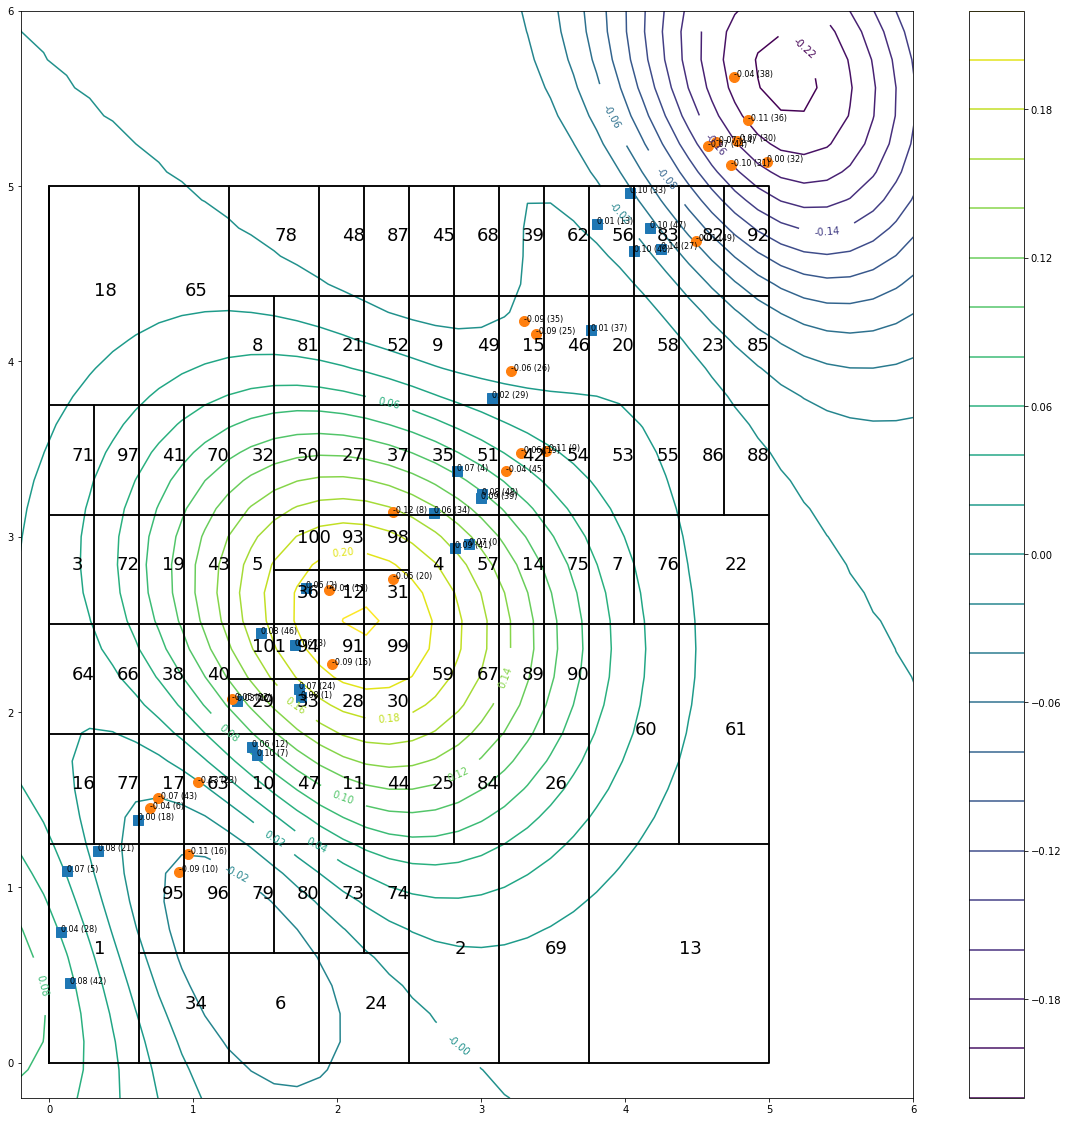

In [6]:
from boundmixofgaussians import zeromean_gaussian_1d, zeromean_gaussian, findbound, PCA

plt.figure(figsize=[20,20])
xs = np.arange(-1,10,0.16)
ys = np.arange(-1,10,0.16)
mg = np.array(np.meshgrid(xs,ys))
grid = np.array([mg[0].flatten(),mg[1].flatten()]).T
v = np.zeros([len(xs),len(ys)])
for eq,eqw in zip(X,EQweights):
    v += eqw*zeromean_gaussian(grid-eq,ls).reshape(len(xs),len(ys))
CS = plt.contour(xs,ys,v,levels=np.arange(-20,20,0.02))
plt.clabel(CS, inline=1, fontsize=10,fmt="%1.2f")
plt.colorbar()



#plt.plot(X[EQweights>0,0],X[EQweights>0,1],'s',markersize=10,label='positive')
#plt.plot(X[EQweights<0,0],X[EQweights<0,1],'o',markersize=10,label='negative')

plt.plot(X[Y[:,0]>0,0],X[Y[:,0]>0,1],'s',markersize=10,label='positive')
plt.plot(X[Y[:,0]<0,0],X[Y[:,0]<0,1],'o',markersize=10,label='negative')
for i, (c,w) in enumerate(zip(X,EQweights)):
    plt.text(c[0],c[1],"%0.2f (%d)"%(w,i),fontsize=8)
#plt.legend()

for idx, (hypercube_start, hypercube_end) in enumerate(zip(hypercube_starts,hypercube_ends)):
    plt.plot([hypercube_start[0],hypercube_start[0],hypercube_end[0],hypercube_end[0],hypercube_start[0]],[hypercube_start[1],hypercube_end[1],hypercube_end[1],hypercube_start[1],hypercube_start[1]],'k-')
    if idx>0: plt.text((hypercube_start[0]+hypercube_end[0])/2,(hypercube_start[1]+hypercube_end[1])/2,idx,fontsize=18)

plt.plot([0,0,5,5,0],[0,5,5,0,0],'k-')
plt.xlim([-.2,6])
plt.ylim([-.2,6])


Why is the bound for MNIST (below) so poor...originally?

Possible reasons;

 - ignoring negatives during the dimensionality reduction - empirically this seems to cause about doubling of the bound
 - high sensitivity due to the rapid change between points of different classes - long lengthscales & high sigma sort of help, but ruin the scale of the response simultaneously.
 - grid too coarse - fixed, just keep < ls/2
 - not enough slices - ugh, more slices don't help .... why??..actually it does a bit - just not so much for dimension 0 which is a weird one (and unfortunately the one I experimented with most) as it's mostly zero (it's the top corner of the images so mostly just black). Note however that the number of splits needs to scale with ?^d, so with these 9 dimensions, to achieve the same improvement as 10 splits in 2d will require ~31000 splits. NOTE: The splitting code is really inefficient at the moment. Including slow test assertions.
 
**I then set the box-size to the maximum value along each axis (so you can't make a pixel brighter than it is in any image). This seemed to make a massive difference - but I'm not sure at all why... surely for most of the space changing the pixel won't have an effect as there's no data there???**

# MNIST

In [5]:
import numpy as np
np.set_printoptions(suppress=True,precision=2)
import matplotlib.pyplot as plt
%matplotlib inline
from GPAdversarialBound import compute_full_bound

In [6]:
from mnist import MNIST
import numpy as np
#download the mnist data from http://yann.lecun.com/exdb/mnist/
#save in mnistdata folder in same directory as this notebook

def getMNISTexample(scalingfactor=7,Ntraining=500):
    mndata = MNIST('./mnistdata')
    mnist_training = mndata.load_training()

    #B = [np.array([[-10.0,20.0],[-10.0,20.0]])]
    bigX = np.array(mnist_training[0])[np.array(mnist_training[1])<2,:]
    bigXtest = bigX[(Ntraining+1):(Ntraining+10),:]
    bigX = bigX[0:Ntraining,:]
    Y = np.array(mnist_training[1])[np.array(mnist_training[1])<2]
    Y = Y[:,None]*2.0-1.0
    Ytest = Y[(Ntraining+1):(Ntraining+10),:]
    Y = Y[0:Ntraining,:]

    def scale(X,res):
        newX = []
        for x in X:
            newx = np.zeros([1+int(28/res),1+int(28/res)])
            xreshaped = x.reshape(28,28)
            for newi,i in enumerate(np.arange(0,28,res)):
                for newj,j in enumerate(np.arange(0,28,res)):
                    newx[newi,newj] = np.mean(xreshaped[i:(i+res),j:(j+res)])
            newX.append(newx.reshape(newx.size))
        return np.array(newX)

    X = scale(bigX,scalingfactor)
    Xtest = scale(bigXtest,scalingfactor)
    newres = int(X[0,:].size**.5)
    return X,Y,Xtest,Ytest

X,Y,Xtest,Ytest = getMNISTexample(scalingfactor=10,Ntraining=50)

In [7]:
#Here we effectively cause a change in lengthscale in different dimensions
#(really the lengthscale stays the same and we scale everything else)
#we assume that we want the lengthscales proportional to the
#standard deviation of the data
#TODO: not sure if this works properly!
#cubesize = np.full(X.shape[1],255)
#cubesize=cubesize/np.std(X,0)
#X=X/np.std(X,0)

In [23]:
ls = 200.0
diff_dim = 4
dims = X.shape[1]
cubesize = np.max(X,0)
splitcount = 100
gridspacing = ls/10.0 #1/10th of ls
sigma = 3.0
bound, hypercube_starts, hypercube_ends, maxseg, EQweights = compute_full_bound(X,Y,sigma,ls,diff_dim,dims,cubesize,splitcount=splitcount,gridspacing=gridspacing,dimthreshold=3)

Splitting...
Computing Paths...
Checking Segments...

0/314....
1/314
2/314...
3/314
4/314...
5/314
6/314...
7/314
8/314..
9/314
10/314..
11/314..
12/314....
13/314
14/314...
15/314
16/314....
17/314...
18/314..
19/314.....
20/314
21/314...
22/314
23/314..
24/314
25/314...
26/314..
27/314...
28/314
29/314..
30/314....
31/314....
32/314
33/314...
34/314...
35/314..
36/314
37/314....
38/314...
39/314...
40/314....
41/314
42/314..
43/314....
44/314....
45/314
46/314....
47/314..
48/314..
49/314
50/314..
51/314..
52/314
53/314...
54/314..
55/314
56/314.....
57/314
58/314
59/314...
60/314....
61/314....
62/314...
63/314..
64/314
65/314...
66/314
67/314
68/314...
69/314..
70/314...
71/314
72/314....
73/314..
74/314..
75/314..
76/314...
77/314....
78/314
79/314...
80/314
81/314....
82/314
83/314..
84/314
85/314..
86/314
87/314...
88/314
89/314....
90/314
91/314..
92/314
93/314...
94/314..
95/314..
96/314..
97/314
98/314....
99/314..
100/314
101/314...
102/314
103/314..
104/314..
105/314
106/3

In [25]:
print(bound[0])
print(maxseg)

0.3286866377233936
[86, 10, 39, 54]


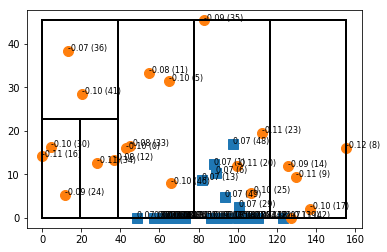

In [26]:
from boundmixofgaussians import zeromean_gaussian_1d, zeromean_gaussian, findbound, PCA
dim0 = diff_dim
dim1 = 2
#plt.figure(figsize=[20,20])

#plt.plot(X[EQweights>0,0],X[EQweights>0,1],'s',markersize=10,label='positive')
#plt.plot(X[EQweights<0,0],X[EQweights<0,1],'o',markersize=10,label='negative')

plt.plot(X[Y[:,0]>0,dim0],X[Y[:,0]>0,dim1],'s',markersize=10,label='positive')
plt.plot(X[Y[:,0]<0,dim0],X[Y[:,0]<0,dim1],'o',markersize=10,label='negative')
for i, (c,w) in enumerate(zip(X,EQweights)):
    plt.text(c[dim0],c[dim1],"%0.2f (%d)"%(w,i),fontsize=8)
#plt.legend()

for idx, (hypercube_start, hypercube_end) in enumerate(zip(hypercube_starts,hypercube_ends)):
    plt.plot([hypercube_start[dim0],hypercube_start[dim0],hypercube_end[dim0],hypercube_end[dim0],hypercube_start[dim0]],[hypercube_start[dim1],hypercube_end[dim1],hypercube_end[dim1],hypercube_start[dim1],hypercube_start[dim1]],'k-')
#    if idx>0: plt.text((hypercube_start[0]+hypercube_end[0])/2,(hypercube_start[1]+hypercube_end[1])/2,idx,fontsize=18)
#
#plt.plot([0,0,5,5,0],[0,5,5,0,0],'k-')
#plt.xlim([-.2,6])
#plt.ylim([-.2,6])


In [27]:
v = np.zeros(len(X))
for eq,eqw in zip(X,EQweights):
    v += eqw*zeromean_gaussian(X-eq,ls)
np.c_[v,Y]

array([[-0.1 , -1.  ],
       [ 0.36,  1.  ],
       [ 0.34,  1.  ],
       [ 0.39,  1.  ],
       [ 0.38,  1.  ],
       [-0.13, -1.  ],
       [ 0.37,  1.  ],
       [ 0.29,  1.  ],
       [ 0.08, -1.  ],
       [-0.01, -1.  ],
       [ 0.37,  1.  ],
       [-0.32, -1.  ],
       [-0.32, -1.  ],
       [ 0.35,  1.  ],
       [-0.2 , -1.  ],
       [ 0.38,  1.  ],
       [-0.03, -1.  ],
       [-0.1 , -1.  ],
       [ 0.23,  1.  ],
       [ 0.39,  1.  ],
       [-0.  , -1.  ],
       [ 0.35,  1.  ],
       [ 0.34,  1.  ],
       [-0.02, -1.  ],
       [-0.22, -1.  ],
       [-0.06, -1.  ],
       [ 0.38,  1.  ],
       [ 0.38,  1.  ],
       [ 0.39,  1.  ],
       [ 0.33,  1.  ],
       [-0.11, -1.  ],
       [ 0.4 ,  1.  ],
       [ 0.34,  1.  ],
       [-0.31, -1.  ],
       [-0.03, -1.  ],
       [-0.21, -1.  ],
       [-0.4 , -1.  ],
       [ 0.39,  1.  ],
       [ 0.32,  1.  ],
       [ 0.37,  1.  ],
       [ 0.33,  1.  ],
       [-0.07, -1.  ],
       [-0.02, -1.  ],
       [ 0.

The largest change between predictions (at the locations of the training points) is...

In [28]:
max(v)-min(v)

0.7974891700116427

The bound on changing the diff_dim is:

In [29]:
bound[0]

0.3286866377233936

Thoughts:
- It's odd splitting the space doesn't seem to help - but that might be due to the space's highish dimensionality
- The poor bound might also be due to more complex structures in the actual data distribution.